In [1]:

# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

# MRI imports
# -----------
import nibabel as nb
import cortex
from cortex import mni

# Functions import
# ----------------
from utils import draw_cortex_vertex, set_pycortex_config_file, eventsMatrix

# GLM imports
# ----------------
from nilearn import image, plotting, surface
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import make_second_level_design_matrix, SecondLevelModel, non_parametric_inference
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_anat, plot_img
from nilearn.image import get_data, math_img


In [7]:
# mount_dir =  sys.argv[1]
mount_dir = '/home/vmorita/disks/scratch_MS/data/PredictEye'
# mount_dir = '/Users/martinszinte/disks/meso_S/data/PredictEye/'
# subject = sys.argv[2]
# session = sys.argv[3]
# task = sys.argv[4] 
# space = sys.argv[5] 
# run = sys.argv[6] 
# preproc = sys.argv[7] 
task = 'SacLoc'
space = 'MNI152NLin2009cAsym'
preproc = 'fmriprep_dct'
contrast='Sac-Fix'
subjects_label = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

# Define folder
# -------------
base_dir = "{}".format(mount_dir)

# Define analysis parameters
# --------------------------
os.chdir('/home/vmorita/disks/meso_H/projects/PredictEye/mri_analysis/')
with open('settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)


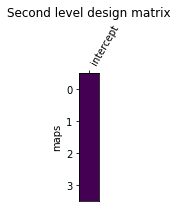

In [5]:
# create design matrix

design_matrix = make_second_level_design_matrix(subjects_label, confounds=None)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('maps')
plt.tight_layout()
plt.show()

In [31]:
# get data from each participant and put together in a list
# create second level model and fit it
imgs = []
for subject in subjects_label:
    glm_folder = '{base_dir}/pp_data/{subject}/glm/fit/'.format(base_dir=base_dir, subject=subject)
    
    effects_map_path = '{glm_folder}{subject}_task-{task}_space-{space}_{preproc}_glm-{contrast}.nii.gz'.\
            format(glm_folder=glm_folder, subject=subject,task=task,space=space,preproc=preproc,contrast=contrast)
    effects_map_tmp = nb.load(effects_map_path)
    # get only the map we are interested in (z_map?)
    effects_map = nb.Nifti1Image(dataobj = effects_map_tmp.dataobj[...,1], affine = effects_map_tmp.affine, header = effects_map_tmp.header)
    
    imgs.append(effects_map)

model = SecondLevelModel(smoothing_fwhm=0.0)
model.fit(imgs, design_matrix=design_matrix)

SecondLevelModel(smoothing_fwhm=5.0)

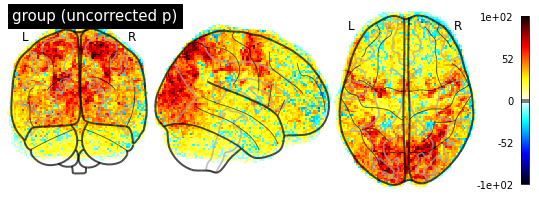

In [12]:
#https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py

# get all maps available 
# plot z-scores
outputs = model.compute_contrast(output_type='all')

p_val = 0.001 #analysis_info['glm_alpha']
p_unc = norm.isf(p_val)
display = plotting.plot_glass_brain(
    outputs['effect_size'], threshold=p_unc, colorbar=True, display_mode='ortho', plot_abs=False,
    title='group (uncorrected p)')
plotting.show()

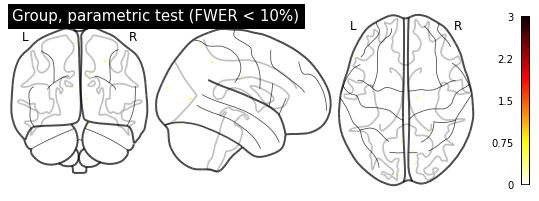

In [33]:
# parametric test

p_val = outputs['p_value']
n_voxels = np.sum(get_data(model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img("-np.log10(np.minimum(1, img * {}))"
                        .format(str(n_voxels)),
                        img=p_val)

cut_coords = [0]
# Since we are plotting negative log p-values and using a threshold equal to 1,
# it corresponds to corrected p-values lower than 10%, meaning that there is
# less than 10% probability to make a single false discovery (90% chance that
# we make no false discovery at all).  This threshold is much more conservative
# than the previous one.
threshold = 1
title = ('Group, parametric test (FWER < 10%)')
display = plotting.plot_glass_brain(neg_log_pval, 
                                    colorbar=True, display_mode='ortho', plot_abs=False, vmax=3,
                                    cut_coords=cut_coords, #threshold=threshold,
                                    title=title)
plotting.show()

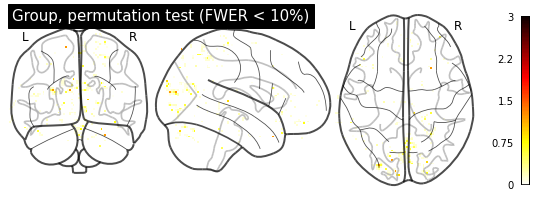

In [34]:
# Non parametric test
neg_log_pvals_permuted_ols_unmasked = non_parametric_inference(imgs,
                                                             design_matrix = design_matrix,
                                                             model_intercept = True, n_perm = 10000,
                                                             two_sided_test = True,
                                                             smoothing_fwhm = 0.0, n_jobs = 1)

title = ('Group, permutation test (FWER < 10%)')
display = plotting.plot_glass_brain(
    neg_log_pvals_permuted_ols_unmasked, colorbar=True, vmax=3,
    display_mode='ortho', plot_abs=False, cut_coords=cut_coords, #threshold=threshold,
    title=title)
plotting.show()

In [18]:
neg_log_pval